In [27]:
import numpy as np
import therpy as tp
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
twopi = 2 * np.pi
import ipywidgets

# Cavity Mode Sum

In [5]:
def step(x, x0):
    if x <= x0: return 0.0
    else: return 1.0
def istep(x, x0):
    if x >= x0: return 0.0
    else: return 1.0

step = np.vectorize(step, excluded='x0')
istep = np.vectorize(istep, excluded='x0')

In [220]:
# Parameters 
c = 1.0
L = 1.0
T = L / c

wl = L / 1
dl = 5.0*L

f = c / wl
w = twopi * f
k = twopi / wl
G = 1.0 / dl

x = np.linspace(0.0, L, 100)

In [221]:
def evens(x, t, n):
    return (t > n*T) * np.exp(- n * G * L) * np.exp(-G * x) * np.sin(k * x - w * (t - n * T)) * istep(x, c * (t - n * T))
def odds(x, t, n):
    return -1 * (t > n*T) * np.exp(- n * G * L) * np.exp(-G * (L - x)) * np.sin(- k * (x - L) - w * (t - n * T)) * step(x, L - c * (t - n * T))
def response(x, t, n=None):
    if n is None: n = int(float(t) / T) + 1
    return np.sum([evens(x, t, ni) for ni in range(0, n, 2)], axis=0) + np.sum([odds(x, t, ni) for ni in range(1, n, 2)], axis=0)

In [222]:
def temp(t = 0.0):
    plt.plot(x, response(x, t))
    plt.ylim([-10, 10])
    plt.xlim([0, L])
    plt.show()
ipywidgets.interact(temp,t=(0, 10.0, 0.01))

<function __main__.temp>

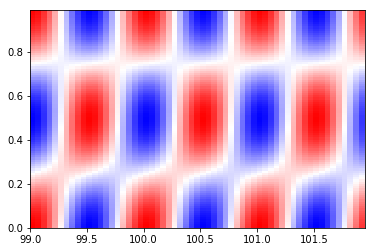

In [223]:
tlist = np.arange(99, 102, 0.05)
movie = np.array(np.diff([response(x, t=ti) for ti in tlist])).T
plt.pcolor(tlist, x[0:-1], movie, cmap='bwr')

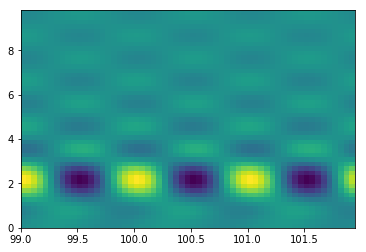

In [224]:
ks = np.pi/L
k = np.arange(0, 5*twopi/L, 0.1*twopi/L)
ft = np.array([np.real(tp.fourier_transform(x[0:-1], movie[:,i], k=k)[1]) for i in range(len(t))]).T
plt.pcolor(t,k/ks,ft)

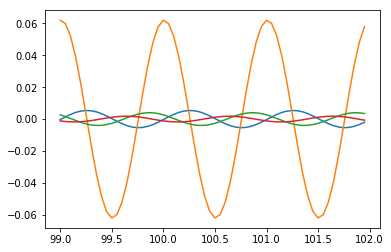

In [231]:
plt.plot(t, ft[5,:])
plt.plot(t, ft[10,:])
plt.plot(t, ft[15,:])
plt.plot(t, ft[20,:])

In [232]:
def fitfun(t, f=1, phase=0, amp=1,):
    return np.cos(twopi*f*t + phase) * amp

cf1 = tp.curve_fit(fitfun, [1, 0, 1], t, ft[5,:], info=True)
cf2 = tp.curve_fit(fitfun, [1, 0, 1], t, ft[10,:], info=True)
cf3 = tp.curve_fit(fitfun, [1, 0, 1], t, ft[15,:], info=True)
cf3 = tp.curve_fit(fitfun, [1, 0, 1], t, ft[20,:], info=True)

       FitValue      FitError Units  Guess  LowerBound  UpperBound     FitError%
f      1.000000  2.251491e-11  None      1        -inf         inf  2.251491e-09
phase  1.510395  1.420948e-08  None      0        -inf         inf  9.407789e-07
amp   -0.005392  6.649975e-13  None      1        -inf         inf  1.233258e-08
       FitValue      FitError Units  Guess  LowerBound  UpperBound     FitError%
f      1.000000  8.168724e-12  None      1        -inf         inf  8.168724e-10
phase -0.051216  5.158779e-09  None      0        -inf         inf  1.007261e-05
amp    0.062038  2.734021e-12  None      1        -inf         inf  4.407029e-09
       FitValue      FitError Units  Guess  LowerBound  UpperBound     FitError%
f      1.000000  5.349637e-11  None      1        -inf         inf  5.349637e-09
phase  0.848864  3.374673e-08  None      0        -inf         inf  3.975517e-06
amp    0.004009  1.159992e-12  None      1        -inf         inf  2.893710e-08
       FitValue      FitErro